In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [3]:
def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f' % err)

In [4]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

In [5]:
import numpy as np
from numpy.core.umath_tests import inner1d
from copy import deepcopy


class SMMEAdaBoostClassifier(object):
    def __init__(self, *args, **kwargs):
        allowed_keys = ['base_learner', 'n_iterations', 'learning_rate', 'random_state']
        keywords_used = kwargs.keys()
        learning_rate = 1
        random_state = None

        if kwargs and not args:
            if 'base_learner' in kwargs:
                base_learner = kwargs.pop('base_learner')
            else:
                raise ValueError('''base_learner can not be None''')
            if 'n_iterations' in kwargs: n_iterations = kwargs.pop('n_iterations')
            if 'learning_rate' in kwargs: learning_rate = kwargs.pop('learning_rate')
            if 'random_state' in kwargs: random_state = kwargs.pop('random_state')

        self.base_learner_ = base_learner
        self.n_iterations_ = n_iterations
        self.learning_rate_ = learning_rate
        self.random_state_ = random_state
        self.estimators_ = list()
        self.estimator_weights_ = np.zeros(self.n_iterations_)
        self.estimator_errors_ = np.ones(self.n_iterations_)


    def fit(self, X, y):
        self.n_samples = X.shape[0]
        self.classes_ = np.array(sorted(list(set(y))))
        self.n_classes_ = len(self.classes_)
        for i in range(self.n_iterations_):
            if i == 0:
                sample_weight = np.ones(self.n_samples) / self.n_samples

            sample_weight, estimator_weight, estimator_error = self.boost(X, y, sample_weight)

            if estimator_error == None:
                break

            self.estimator_errors_[i] = estimator_error
            self.estimator_weights_[i] = estimator_weight

            if estimator_error <= 0:
                break

        return self
    

    def boost(self, X, y, sample_weight):
        estimator = deepcopy(self.base_learner_)
        if self.random_state_:
            estimator.set_params(random_state=1)

        estimator.fit(X, y, sample_weight=sample_weight)

        y_pred = estimator.predict(X)
        incorrect = y_pred != y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)

       
        if estimator_error >= 1 - 1 / self.n_classes_:
            return None, None, None

       
        estimator_weight = self.learning_rate_ * np.log((1 - estimator_error) / estimator_error) + np.log(
            self.n_classes_ - 1)

        if estimator_weight <= 0:
            return None, None, None

       
        sample_weight *= np.exp(estimator_weight * incorrect)

        sample_weight_sum = np.sum(sample_weight, axis=0)
        if sample_weight_sum <= 0:
            return None, None, None

 
        sample_weight /= sample_weight_sum

        self.estimators_.append(estimator)

        return sample_weight, estimator_weight, estimator_error

    def predict(self, X):
        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]
        pred = None

        pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))

        pred /= self.estimator_weights_.sum()
        if n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)


    def predict_proba(self, X):
        proba = sum(estimator.predict_proba(X) * w
                        for estimator, w in zip(self.estimators_,
                                                self.estimator_weights_))

        proba /= self.estimator_weights_.sum()
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

In [6]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss

%config InlineBackend.figure_format='svg'
%matplotlib inline

In [8]:
covertype_path = 'covtype.data'

names = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
]

Wilderness_Area = []
for i in range(4):
    Wilderness_Area.append('Wilderness_Area_{}'.format(i+1))
    print('Wilderness_Area_{}'.format(i+1))

Soil_Type = []
for i in range(40):
    Soil_Type.append('Soil_Type_{}'.format(i+1))

names.extend(Wilderness_Area + Soil_Type + ['Cover_Type'])
covertype_df = pd.read_csv(covertype_path, names=names)

Wilderness_Area_1
Wilderness_Area_2
Wilderness_Area_3
Wilderness_Area_4


In [9]:
covertype_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [10]:
X = covertype_df.drop('Cover_Type',axis=1)
y = covertype_df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25, random_state=42)

In [80]:
train_accuracy = {}
test_accuracy = {}
for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=1),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    print(iter)
    y_pred = classifier.predict(X_test)
    S = accuracy_score(y_test, y_pred)
    test_accuracy[iter] = S
    print(S)
    y_pred1 = classifier.predict(X_train)
    S1 = accuracy_score(y_train, y_pred1)
    train_accuracy[iter] = S1
    print(S1)

1
0.633563506434
0.633581865205
11
0.634919760693
0.635252513431
21
0.620820224023
0.622114517428
31
0.644971188203
0.645666526681
41
0.646086483584
0.6462058156
51
0.646258597069
0.646391698163
61
0.6294327828
0.630235979062
71
0.619457085224
0.619968835985
81
0.644386002355
0.645792743237
91
0.633054050519
0.634740762669
101
0.609715461987
0.61141364837
111
0.61351572773
0.615333246129
121
0.600194144011
0.602404081155
131
0.584600662293
0.585429101866
141
0.614155989893
0.616028584608
151
0.618899437533
0.619590186319


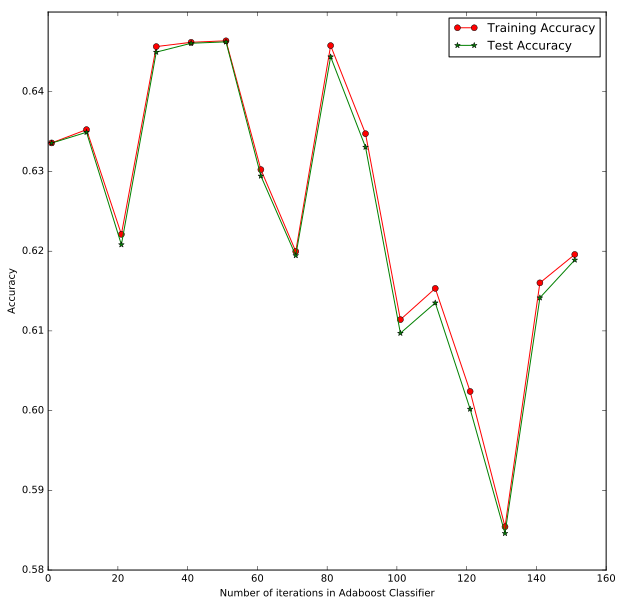

In [81]:
train_accuracyDS=[]
test_accuracyDS=[]


for i in range(1,160,10):
    train_accuracyDS.append(train_accuracy[i])
    test_accuracyDS.append(test_accuracy[i])


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.plot(range(1,160,10),train_accuracyDS,marker='o',color='r',label='Training Accuracy')
plt.plot(range(1,160,10),test_accuracyDS,marker='*',color='g',label='Test Accuracy')


plt.xlabel('Number of iterations in Adaboost Classifier')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [11]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(train_accuracy[81], classes=labels,title='Decision Stump(Cover)- Conf. Matrix on training set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(train_accuracy[81], classes=labels, normalize=True,title='Decision Stump(Cover)- Normalized Conf. Matrix on training set')
plt.show()


labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_accuracy[81], classes=labels,title='Decision Stump(Cover)- Conf. Matrix on test set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(test_accuracy[81], classes=labels, normalize=True,title='Decision Stump(Cover)- Normalized Conf. Matrix on test set')
plt.show()



In [80]:
from collections import Counter
from sklearn.metrics import confusion_matrix
print('Shape of the test set {}'.format(Counter(y_test)))

for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=1),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(iter)
    C = confusion_matrix(y_test, y_pred)
    C = C / C.astype(np.float).sum(axis = 1)
    C = np.asarray(C)
    C = np.around(C, decimals =2)
    print(C)


    y_pred = classifier.predict(X_train)
    C1 = confusion_matrix(y_train, y_pred)
    C1 = C1 / C1.astype(np.float).sum(axis = 1)
    C1 = np.asarray(C1)
    C1 = np.around(C1, decimals =2)
    print(C1)


Shape of the test set Counter({2: 70776, 1: 53006, 3: 8909, 7: 5065, 6: 4373, 5: 2473, 4: 651})
1
[[ 0.73  0.2   0.    0.    0.    0.    0.  ]
 [ 0.33  0.75  0.    0.    0.    0.    0.  ]
 [ 0.    0.13  0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.03  0.    0.    0.    0.    0.  ]
 [ 0.    0.06  0.    0.    0.    0.    0.  ]
 [ 0.1   0.    0.    0.    0.    0.    0.  ]]
[[ 0.73  0.2   0.    0.    0.    0.    0.  ]
 [ 0.33  0.76  0.    0.    0.    0.    0.  ]
 [ 0.    0.13  0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.03  0.    0.    0.    0.    0.  ]
 [ 0.    0.06  0.    0.    0.    0.    0.  ]
 [ 0.1   0.    0.    0.    0.    0.    0.  ]]
11
[[ 0.73  0.2   0.04  0.    0.    0.    0.  ]
 [ 0.33  0.64  0.92  0.    0.    0.    0.  ]
 [ 0.    0.01  0.94  0.    0.    0.    0.  ]
 [ 0.    0.    0.07  0.    0.    0.    0.  ]
 [ 0.    0.03  0.03  0.    0.    0.    0.  ]
 [ 0.    0.01  0.45  0.    0.    0.    0. 

In [12]:
train_accuracy_coverdt10 = {}
test_accuracy_coverdt10 = {}


for iter in range(1,150,20):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    print(iter)
    y_pred = classifier.predict(X_test)
    S = accuracy_score(y_test, y_pred)
    test_accuracy_coverdt10[iter] = S
    print(S)
    y_pred1 = classifier.predict(X_train)
    S1 = accuracy_score(y_train, y_pred1)
    train_accuracy_coverdt10[iter] = S1
    print(S1)

1
0.777099268173
0.781372272288
21
0.812175996365
0.830950135281
41
0.819446069961
0.84330558864
61
0.826544030072
0.850901530433
81
0.830681638245
0.856060345283
101
0.836650533896
0.863509416902
121
0.839789883858
0.865714764354
141
0.846612462393
0.872211474691


In [16]:
for iter in range(161,190,20):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    print(iter)
    y_pred = classifier.predict(X_test)
    S = accuracy_score(y_test, y_pred)
    test_accuracy_coverdt10[iter] = S
    print(S)
    y_pred1 = classifier.predict(X_train)
    S1 = accuracy_score(y_train, y_pred1)
    train_accuracy_coverdt10[iter] = S1
    print(S1)

161
0.845951546612
0.87286091624
181
0.850054732088
0.876470709727


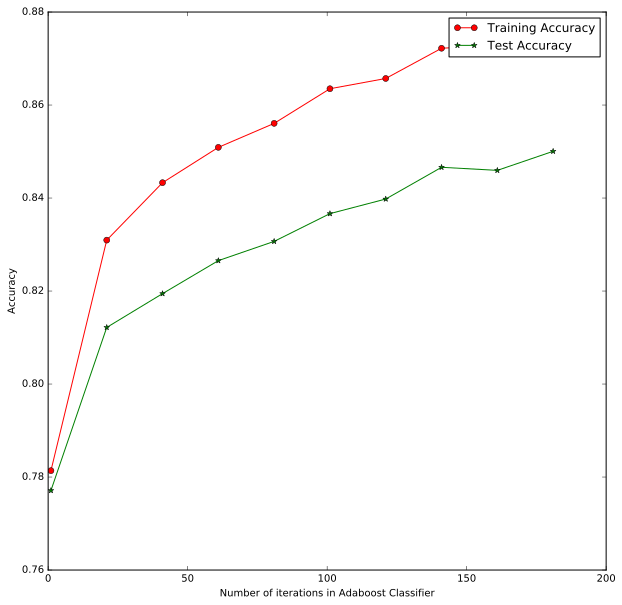

In [18]:
train_accuracyDt10_cover=[]
test_accuracyDt10_cover=[]


for i in range(1,190,20):
    train_accuracyDt10_cover.append(train_accuracy_coverdt10[i])
    test_accuracyDt10_cover.append(test_accuracy_coverdt10[i])


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.plot(range(1,190,20),train_accuracyDt10_cover,marker='o',color='r',label='Training Accuracy')
plt.plot(range(1,190,20),test_accuracyDt10_cover,marker='*',color='g',label='Test Accuracy')


plt.xlabel('Number of iterations in Adaboost Classifier')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [ ]:
classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= iter,learning_rate=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(iter)
C = confusion_matrix(y_test, y_pred)
C = C / C.astype(np.float).sum(axis = 1)
C = np.asarray(C)
C = np.around(C, decimals =2)
print(C)


y_pred = classifier.predict(X_train)
C1 = confusion_matrix(y_train, y_pred)
C1 = C1 / C1.astype(np.float).sum(axis = 1)
C1 = np.asarray(C1)
C1 = np.around(C1, decimals =2)
print(C1)

In [79]:
#for a decision tree classifier with max depth = 10
for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(iter)
    C = confusion_matrix(y_test, y_pred)
    C = C / C.astype(np.float).sum(axis = 1)
    C = np.asarray(C)
    C = np.around(C, decimals =2)
    print(C)


    y_pred = classifier.predict(X_train)
    C1 = confusion_matrix(y_train, y_pred)
    C1 = C1 / C1.astype(np.float).sum(axis = 1)
    C1 = np.asarray(C1)
    C1 = np.around(C1, decimals =2)
    print(C1)

1
[[ 0.78  0.16  0.    0.    0.    0.    0.09]
 [ 0.22  0.82  0.06  0.    0.04  0.08  0.  ]
 [ 0.    0.01  0.84  0.11  0.    0.13  0.  ]
 [ 0.    0.    0.02  0.61  0.    0.01  0.  ]
 [ 0.    0.02  0.    0.    0.22  0.    0.  ]
 [ 0.    0.02  0.19  0.03  0.    0.35  0.  ]
 [ 0.03  0.    0.    0.    0.    0.    0.71]]
[[ 0.78  0.16  0.    0.    0.    0.    0.09]
 [ 0.22  0.83  0.05  0.    0.03  0.07  0.  ]
 [ 0.    0.01  0.84  0.12  0.    0.12  0.  ]
 [ 0.    0.    0.02  0.65  0.    0.01  0.  ]
 [ 0.    0.02  0.    0.    0.22  0.    0.  ]
 [ 0.    0.02  0.18  0.02  0.    0.37  0.  ]
 [ 0.03  0.    0.    0.    0.    0.    0.72]]
11
[[ 0.76  0.17  0.    0.    0.02  0.    0.13]
 [ 0.2   0.83  0.04  0.    0.26  0.06  0.01]
 [ 0.    0.01  0.86  0.1   0.01  0.17  0.  ]
 [ 0.    0.    0.01  0.76  0.    0.01  0.  ]
 [ 0.    0.01  0.    0.    0.55  0.    0.  ]
 [ 0.    0.01  0.08  0.04  0.    0.73  0.  ]
 [ 0.02  0.    0.    0.    0.    0.    0.82]]
[[ 0.77  0.16  0.    0.    0.02  0.    0.12]
 [

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

mnist_path = 'train_mnist.csv'
mnist_df = pd.read_csv(mnist_path, header=None)

In [13]:
mnist_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42000,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
mnist_df=mnist_df.rename(index=int, columns={0: "class"})

In [15]:
mnist_df.tail()

,class,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42000,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
a=mnist_df['class']

In [17]:
del mnist_df['class']

In [18]:
mnist_df.insert(784,'class',a)

In [19]:
mnist_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,776,777,778,779,780,781,782,783,784,class
41996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
41999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
42000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [20]:
mnist_df = mnist_df.ix[1:]

In [21]:
mnist=mnist_df.as_matrix()
mnist.shape

(42000, 785)

In [22]:
mnist[:5]

array([['0', '0', '0', ..., '0', '0', '1'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '1'],
       ['0', '0', '0', ..., '0', '0', '4'],
       ['0', '0', '0', ..., '0', '0', '0']], dtype=object)

In [24]:

from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(mnist[:,0:784],mnist[:,784], test_size=0.25, random_state=42)

X_train = X_train.astype(int)
y_train = y_train.astype(int)
X_test = X_test.astype(int)
y_test = y_test.astype(int)

In [68]:
train_accuracy = {}
test_accuracy = {}

for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=1),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    print(iter)
    y_pred = classifier.predict(X_test)
    S = accuracy_score(y_test, y_pred)
    test_accuracy[iter] = S
    print(S)
    y_pred1 = classifier.predict(X_train)
    S1 = accuracy_score(y_train, y_pred1)
    train_accuracy[iter] = S1
    print(S1)

1
0.191428571429
0.19419047619
11
0.32419047619
0.314666666667
21
0.545047619048
0.541015873016
31
0.61019047619
0.612380952381
41
0.623523809524
0.619174603175
51
0.646380952381
0.646952380952
61
0.698666666667
0.703301587302
71
0.721619047619
0.723841269841
81
0.732761904762
0.737365079365
91
0.732666666667
0.733079365079
101
0.740666666667
0.737333333333
111
0.736
0.734952380952
121
0.74219047619
0.742825396825
131
0.761619047619
0.760126984127
141
0.752761904762
0.752603174603
151
0.75980952381
0.759047619048


In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals = 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
#131
classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=1),n_iterations= 131,learning_rate=1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
testAccuracy = confusion_matrix(y_test, y_pred)

y_pred = classifier.predict(X_train)
trainAccuracy = confusion_matrix(y_train, y_pred)

Confusion matrix, without normalization
[[2349    0   21   58    7  573   43    9   39    8]
 [   0 3255   76   50    4   33   12   16   89    3]
 [  40   76 2302  106   79   57  235   65  122   23]
 [  86   33   79 2187   13  317   45   83  329   28]
 [   5    9   52   75 2285   22   37   49  196  318]
 [  76   42   22  337   57 1952   76   28  245   62]
 [  35   16  129   16  184  126 2559    3   55    4]
 [  37   29   50   48   87   22    0 2738   31  224]
 [  15   87   65  198   21  122   44   32 2394   80]
 [  20   15   51  158  431   40    3  276  237 1923]]
Normalized confusion matrix
[[ 0.76  0.    0.01  0.02  0.    0.18  0.01  0.    0.01  0.  ]
 [ 0.    0.92  0.02  0.01  0.    0.01  0.    0.    0.03  0.  ]
 [ 0.01  0.02  0.74  0.03  0.03  0.02  0.08  0.02  0.04  0.01]
 [ 0.03  0.01  0.02  0.68  0.    0.1   0.01  0.03  0.1   0.01]
 [ 0.    0.    0.02  0.02  0.75  0.01  0.01  0.02  0.06  0.1 ]
 [ 0.03  0.01  0.01  0.12  0.02  0.67  0.03  0.01  0.08  0.02]
 [ 0.01  0.01  0.04  0.

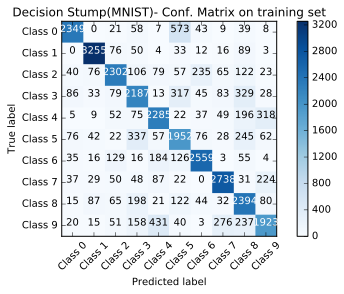

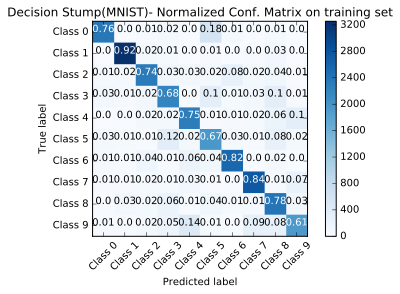

Confusion matrix, without normalization
[[ 777    0    7   22    1  191   12    1   12    2]
 [   0 1073   24    5    0    8    7    1   26    2]
 [  14   26  768   48   32   21   85   26   44    8]
 [  29   11   25  792    6  125   11   36  103   13]
 [   3    1   14   15  798   14   13   12   58   96]
 [  14   14    9  101   23  606   43    8   69   11]
 [  17    3   57    5   71   37  793    3   23    1]
 [   7   13   23   22   39    5    0  932   10   84]
 [   2   29   13   56    5   33   11    5  829   22]
 [   9    3   20   43  162   20    0   85   63  629]]
Normalized confusion matrix
[[ 0.76  0.    0.01  0.02  0.    0.19  0.01  0.    0.01  0.  ]
 [ 0.    0.94  0.02  0.    0.    0.01  0.01  0.    0.02  0.  ]
 [ 0.01  0.02  0.72  0.04  0.03  0.02  0.08  0.02  0.04  0.01]
 [ 0.03  0.01  0.02  0.69  0.01  0.11  0.01  0.03  0.09  0.01]
 [ 0.    0.    0.01  0.01  0.78  0.01  0.01  0.01  0.06  0.09]
 [ 0.02  0.02  0.01  0.11  0.03  0.67  0.05  0.01  0.08  0.01]
 [ 0.02  0.    0.06  0.

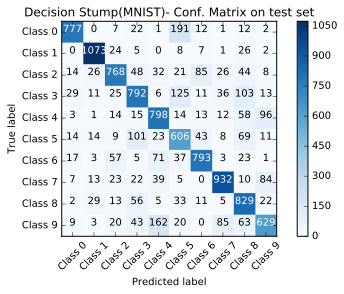

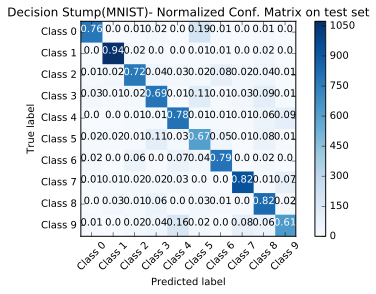

In [67]:
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(trainAccuracy, classes=labels,title='Decision Stump(MNIST)- Conf. Matrix on training set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(trainAccuracy, classes=labels, normalize=True,title='Decision Stump(MNIST)- Normalized Conf. Matrix on training set')
plt.show()


labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(testAccuracy, classes=labels,title='Decision Stump(MNIST)- Conf. Matrix on test set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(testAccuracy, classes=labels, normalize=True,title='Decision Stump(MNIST)- Normalized Conf. Matrix on test set')
plt.show()



In [71]:
train_accuracy_array=[]
test_accuracy_array=[]


for i in range(1,160,10):
    train_accuracy_array.append(train_accuracy[i])
    test_accuracy_array.append(test_accuracy[i])

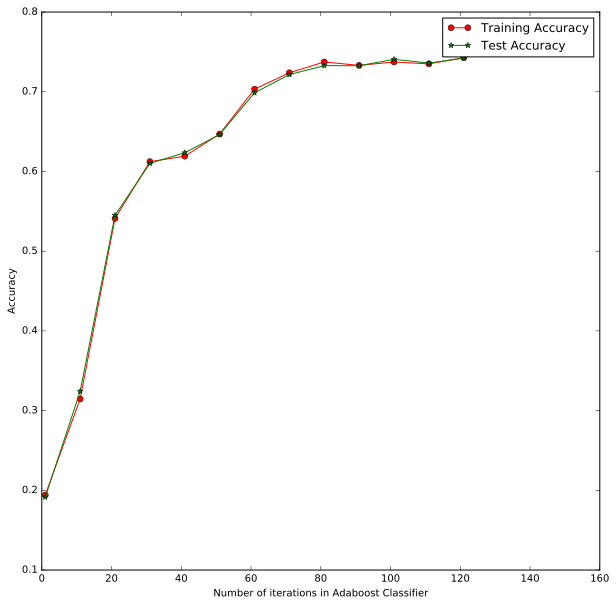

In [72]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.plot(range(1,160,10),train_accuracy_array,marker='o',color='r',label='Training Accuracy')
plt.plot(range(1,160,10),test_accuracy_array,marker='*',color='g',label='Test Accuracy')




plt.xlabel('Number of iterations in Adaboost Classifier')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [52]:
from collections import Counter
from sklearn.metrics import confusion_matrix
print('Shape of the test set {}'.format(Counter(y_test)))

for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=1),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(iter)
    C = confusion_matrix(y_test, y_pred)
    C = C / C.astype(np.float).sum(axis = 1)
    C = np.asarray(C)
    C = np.around(C, decimals =2)
    print(C)


    y_pred = classifier.predict(X_train)
    C1 = confusion_matrix(y_train, y_pred)
    C1 = C1 / C1.astype(np.float).sum(axis = 1)
    C1 = np.asarray(C1)
    C1 = np.around(C1, decimals =2)
    print(C1)


Shape of the test set Counter({3: 1151, 1: 1146, 7: 1135, 2: 1072, 9: 1034, 0: 1025, 4: 1024, 6: 1010, 8: 1005, 5: 898})
1
[[ 0.    0.76  0.    0.    0.    0.    0.    0.    0.    0.15]
 [ 0.    0.89  0.    0.    0.    0.    0.    0.    0.    0.12]
 [ 0.    0.28  0.    0.    0.    0.    0.    0.    0.    0.73]
 [ 0.    0.2   0.    0.    0.    0.    0.    0.    0.    0.89]
 [ 0.    0.04  0.    0.    0.    0.    0.    0.    0.    0.94]
 [ 0.    0.34  0.    0.    0.    0.    0.    0.    0.    0.49]
 [ 0.    0.16  0.    0.    0.    0.    0.    0.    0.    0.8 ]
 [ 0.    0.11  0.    0.    0.    0.    0.    0.    0.    0.98]
 [ 0.    0.23  0.    0.    0.    0.    0.    0.    0.    0.72]
 [ 0.    0.04  0.    0.    0.    0.    0.    0.    0.    0.96]]
[[ 0.    0.73  0.    0.    0.    0.    0.    0.    0.    0.17]
 [ 0.    0.88  0.    0.    0.    0.    0.    0.    0.    0.14]
 [ 0.    0.23  0.    0.    0.    0.    0.    0.    0.    0.72]
 [ 0.    0.18  0.    0.    0.    0.    0.    0.    0.    

In [ ]:
train_accuracy_dt10 = {}
test_accuracy_dt10 = {}
for iter in range(1,160,10):
    classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= iter,learning_rate=1)
    classifier.fit(X_train, y_train)
    print(iter)
    y_pred = classifier.predict(X_test)
    S = accuracy_score(y_test, y_pred)
    test_accuracy_dt10[iter] = S
    print(S)
    
    y_pred1 = classifier.predict(X_train)
    S1 = accuracy_score(y_train, y_pred1)
    train_accuracy_dt10[iter] = S1
    print(S1)

1
0.842952380952
0.905968253968
11
0.927714285714
0.996761904762
21
0.941714285714
0.999682539683
31
0.946857142857
0.999936507937
41
0.951523809524
1.0
51
0.956285714286
0.999968253968
61
0.959142857143
0.999968253968
71
0.959428571429
1.0
81
0.960952380952
1.0
91
0.964285714286
1.0
101
0.963904761905
1.0
111
0.963619047619
1.0
121
0.962952380952
1.0
131
0.965333333333
1.0


In [26]:
#91
classifier = SMMEAdaBoostClassifier(base_learner = DecisionTreeClassifier(max_depth=10),n_iterations= 91,learning_rate=1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
testAccuracyDt10 = confusion_matrix(y_test, y_pred)

y_pred = classifier.predict(X_train)
trainAccuracyDt10 = confusion_matrix(y_train, y_pred)

Confusion matrix, without normalization
[[3107    0    0    0    0    0    0    0    0    0]
 [   0 3538    0    0    0    0    0    0    0    0]
 [   0    0 3105    0    0    0    0    0    0    0]
 [   0    0    0 3200    0    0    0    0    0    0]
 [   0    0    0    0 3048    0    0    0    0    0]
 [   0    0    0    0    0 2897    0    0    0    0]
 [   0    0    0    0    0    0 3127    0    0    0]
 [   0    0    0    0    0    0    0 3266    0    0]
 [   0    0    0    0    0    0    0    0 3058    0]
 [   0    0    0    0    0    0    0    0    0 3154]]
Normalized confusion matrix
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. 

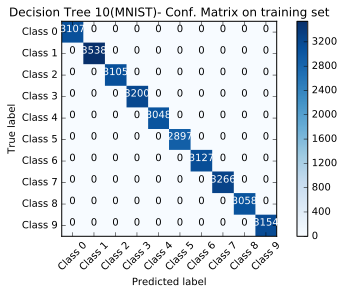

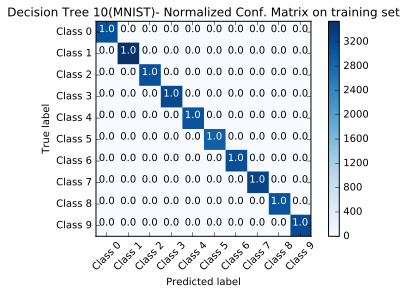

Confusion matrix, without normalization
[[1012    0    2    1    2    3    2    0    3    0]
 [   0 1136    3    0    1    1    2    1    0    2]
 [   2    6 1024   10    6    3    3    5   12    1]
 [   0    2    7 1093    1   14    0    6   16   12]
 [   2    0    0    0  991    0    3    3    4   21]
 [   0    0    2   16    0  859    7    1    6    7]
 [   9    2    2    0    3    6  976    0   12    0]
 [   1    5   15    0    8    0    0 1068    4   34]
 [   0    5    4    4    6    3    3    0  971    9]
 [   4    1    2   13    9    3    1    8    3  990]]
Normalized confusion matrix
[[ 0.99  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.99  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.96  0.01  0.01  0.    0.    0.    0.01  0.  ]
 [ 0.    0.    0.01  0.95  0.    0.01  0.    0.01  0.01  0.01]
 [ 0.    0.    0.    0.    0.97  0.    0.    0.    0.    0.02]
 [ 0.    0.    0.    0.02  0.    0.96  0.01  0.    0.01  0.01]
 [ 0.01  0.    0.    0.

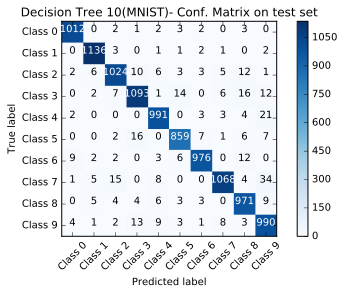

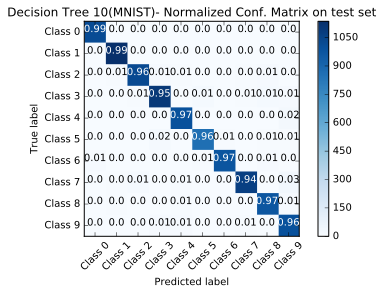

In [29]:
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(trainAccuracyDt10, classes=labels,title='Decision Tree 10(MNIST)- Conf. Matrix on training set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(trainAccuracyDt10, classes=labels, normalize=True,title='Decision Tree 10(MNIST)- Normalized Conf. Matrix on training set')
plt.show()


labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(testAccuracyDt10, classes=labels,title='Decision Tree 10(MNIST)- Conf. Matrix on test set')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(testAccuracyDt10, classes=labels, normalize=True,title='Decision Tree 10(MNIST)- Normalized Conf. Matrix on test set')
plt.show()



In [77]:
train_accuracyDt10=[]
test_accuracyDt10=[]

print(train_accuracy_dt10)
for i in range(1,140,10):
    train_accuracyDt10.append(train_accuracy_dt10[i])
    test_accuracyDt10.append(test_accuracy_dt10[i])

{1: 0.90596825396825398, 131: 1.0, 101: 1.0, 71: 1.0, 41: 1.0, 11: 0.99676190476190474, 141: 1.0, 111: 1.0, 81: 1.0, 51: 0.99996825396825395, 21: 0.99968253968253973, 151: 1.0, 121: 1.0, 91: 1.0, 61: 0.99996825396825395, 31: 0.9999365079365079}


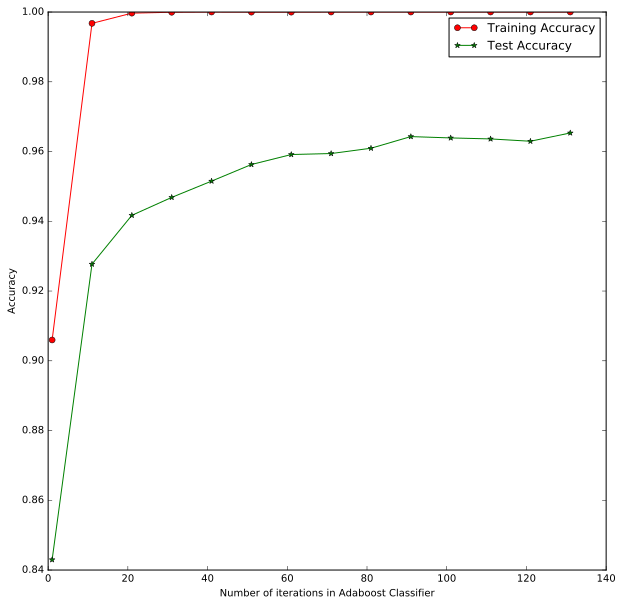

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

plt.plot(range(1,140,10),train_accuracyDt10,marker='o',color='r',label='Training Accuracy')
plt.plot(range(1,140,10),test_accuracyDt10,marker='*',color='g',label='Test Accuracy')


plt.xlabel('Number of iterations in Adaboost Classifier')
plt.ylabel('Accuracy')

plt.legend()

plt.show()